# Modelling for image classification

1. Collect and prepare the data: Gather a large dataset of images that represent your target classes. Ensure that the images are cleanly labelled, and the dataset is balanced across classes. Then, preprocess the images by resizing them to a consistent size and normalizing their pixel values to a standard range. Data is already given in the problem-set URL

2. Define the architecture: Select an appropriate architecture for your model, considering factors like complexity, accuracy, and compatibility with your dataset. The models that i test are:
- Traditional CNN, (Baseline)
- ResNet
- MobileNet

3. Train the model: Train the model on the dataset by feeding it input images and target labels. Specify the loss function, optimizer, and learning rate, and tune them to achieve optimal performance. Monitor the accuracy and loss during training using metrics like accuracy score and confusion matrix.

4. Validate the model: After training, evaluate the model on a validation dataset to determine its accuracy and generalization capability. Tweak the model parameters to improve accuracy and decrease overfitting if the validation accuracy is low.

5. Test the model: Once the model has been adequately validated, test it on a test dataset to gauge its performance on new, unseen data.

In [1]:
import os
import numpy as np
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input as pi_resnet
from tensorflow.keras.applications.mobilenet import preprocess_input as pi_mobilenet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Dense, GlobalAveragePooling2D, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

# # If ran from Google colab
# from google.colab import drive
# drive.mount('/content/drive')

Declare Config and Constants

In [2]:

# Constants and Configs
TRAIN_DATA_DIR = "datasets/ps-1/train"
VALIDATION_DATA_DIR = "datasets/ps-1/validation"
TEST_DATA_DIR = "datasets/ps-1/test"
IMG_WIDTH, IMG_HEIGHT = 128, 128
BATCH_SIZE = 32
NUM_EPOCHS = 10
NUM_CLASSES = 4
MODEL = "cnn"


## Data Visualization

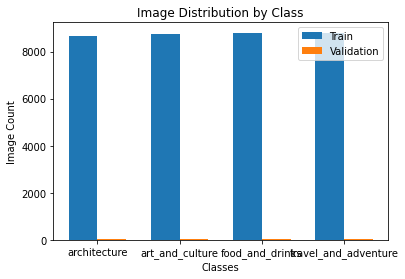

In [3]:
import os
import matplotlib.pyplot as plt

def count_images_in_folder(folder_path):
    return sum([len(files) for _, _, files in os.walk(folder_path)])

def visualize_data_distribution(train_data_dir, validation_data_dir, classes):
    train_counts = [count_images_in_folder(os.path.join(train_data_dir, cls)) for cls in classes]
    validation_counts = [count_images_in_folder(os.path.join(validation_data_dir, cls)) for cls in classes]
    
    fig, ax = plt.subplots()
    x = np.arange(len(classes))
    bar_width = 0.35

    train_bars = ax.bar(x - bar_width/2, train_counts, bar_width, label='Train')
    validation_bars = ax.bar(x + bar_width/2, validation_counts, bar_width, label='Validation')

    ax.set_xlabel('Classes')
    ax.set_ylabel('Image Count')
    ax.set_title('Image Distribution by Class')
    ax.set_xticks(x)
    ax.set_xticklabels(classes)
    ax.legend()

    plt.show()

classes = ['architecture', 'art_and_culture', 'food_and_drinks', 'travel_and_adventure']
visualize_data_distribution(TRAIN_DATA_DIR, VALIDATION_DATA_DIR, classes)


From the visualization above, we can tell that the dataset is very balanced already, with about 9000 image per classes in training dataset and about less than 100 in validation dataset. Because the dataset is already manually split by the author i will not perform any manual split and will perform the model evaluation and training with the data as is given. 

## Data Cleansing and Augmentation


In [15]:
def prepare_generator_dataset(preprocess_input):
  # Prepare data generators for training and validation
  train_datagen = ImageDataGenerator(
      preprocessing_function=preprocess_input,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

  validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

  train_generator = train_datagen.flow_from_directory(
      TRAIN_DATA_DIR,
      target_size=(IMG_WIDTH, IMG_HEIGHT),
      batch_size=BATCH_SIZE,
      class_mode='categorical')

  validation_generator = validation_datagen.flow_from_directory(
      VALIDATION_DATA_DIR,
      target_size=(IMG_WIDTH, IMG_HEIGHT),
      batch_size=BATCH_SIZE,
      class_mode='categorical')
  
  return train_generator, validation_generator

## Model Training

In [5]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model


def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 6), facecolor='w')
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

def get_cm(model, test_generator):
    # Function to plot confusion matrix
    def plot_confusion_matrix(conf_matrix, classes, normalize=False, cmap=plt.cm.Blues):
        if normalize:
            conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

        plt.figure(figsize=(8, 8), facecolor='w')
        plt.imshow(conf_matrix, interpolation='nearest', cmap=cmap)
        plt.title('Confusion Matrix')
        plt.colorbar()

        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = '.2f' if normalize else 'd'
        thresh = conf_matrix.max() / 2.
        for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
            plt.text(j, i, format(conf_matrix[i, j], fmt),
                    horizontalalignment="center",
                    color="white" if conf_matrix[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()

    # Get predictions on the test set
    y_pred = model.predict(test_generator, steps=np.ceil(test_generator.samples / BATCH_SIZE))
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Get true labels from the test generator
    y_true = test_generator.classes
    class_names = list(test_generator.class_indices.keys()) 

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred_classes)

    # Plot confusion matrix
    plot_confusion_matrix(conf_matrix, classes=class_names, normalize=True)

def load_saved_model(model_path):
    model = load_model(model_path)
    return model


### MobileNet

In [6]:
def create_and_fit_model_mobilenet(train_generator, validation_generator):

  # Load pre-trained MobileNet model without the top layers
  base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))


  # Add custom layers
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(64, activation='relu')(x)
  x = Dropout(0.5)(x)
  predictions = Dense(NUM_CLASSES, activation='softmax')(x)

  # Create the final model
  model = Model(inputs=base_model.input, outputs=predictions)

  # Freeze the layers of the base model (MobileNet-50) during training
  for layer in base_model.layers:
      layer.trainable = False

  # Compile the model
  model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
  import matplotlib.pyplot as plt

  # Train the model
  history = model.fit(
      train_generator,
      steps_per_epoch=np.ceil(train_generator.samples / BATCH_SIZE),
      epochs=NUM_EPOCHS,
      validation_data=validation_generator,
      validation_steps=np.ceil(validation_generator.samples / BATCH_SIZE))

  return model, history


### ResNet

In [7]:
def create_and_fit_model_resnet(train_generator, validation_generator):

  # Load pre-trained ResNet-50 model without the top layers
  base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

  # Add custom layers
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(64, activation='relu')(x)
  x = Dropout(0.5)(x)
  predictions = Dense(NUM_CLASSES, activation='softmax')(x)

  # Create the final model
  model = Model(inputs=base_model.input, outputs=predictions)

  # Freeze the layers of the base model (ResNet-50) during training
  for layer in base_model.layers:
      layer.trainable = False

  # Compile the model
  model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
  import matplotlib.pyplot as plt

  # Train the model
  history = model.fit(
      train_generator,
      steps_per_epoch=np.ceil(train_generator.samples / BATCH_SIZE),
      epochs=NUM_EPOCHS,
      validation_data=validation_generator,
      validation_steps=np.ceil(validation_generator.samples / BATCH_SIZE))

  return model, history


### Traditional CNN


In [8]:

def create_and_fit_model_cnn(train_generator, validation_generator):
  # Create the CNN model
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(128, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(NUM_CLASSES, activation='softmax'))

  # Compile the model
  model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

  # Train the model
  history = model.fit(
      train_generator,
      steps_per_epoch=np.ceil(train_generator.samples / BATCH_SIZE),
      epochs=NUM_EPOCHS,
      validation_data=validation_generator,
      validation_steps=np.ceil(validation_generator.samples / BATCH_SIZE))

  return model, history

## Final Output

In [18]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model

def predict_images(train_generator, model, test_dir, img_width=224, img_height=224, preprocess_input=None):
    class_labels = {v: k for k, v in train_generator.class_indices.items()}
    test_images = os.listdir(test_dir)
    
    for img_name in test_images:
        img_path = os.path.join(test_dir, img_name)
        img = load_img(img_path, target_size=(img_width, img_height))
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        if preprocess_input:
            img_array = preprocess_input(img_array)
        
        prediction = model.predict(img_array)
        predicted_class = class_labels[np.argmax(prediction)]

        print(f"{img_name}: {predicted_class}")



In [10]:
preprocess_input = None

if MODEL == "resnet50":
  
  model_path = 'resnet_image_classification.h5'
  
  if os.path.exists(model_path):
      print("Loading saved model...")
      model = load_saved_model(model_path)
  else:
    preprocess_input = pi_resnet
    train_generator, validation_generator = prepare_generator_dataset(preprocess_input)
    model, history = create_and_fit_model_resnet(train_generator, validation_generator)
    model.save(model_path)

if MODEL == "mobilenet":
  
  model_path = 'mobilenet_image_classification.h5'
  
  if os.path.exists(model_path):
      print("Loading saved model...")
      model = load_saved_model(model_path)
  else:
    preprocess_input = pi_mobilenet
    train_generator, validation_generator = prepare_generator_dataset(preprocess_input)
    model, history = create_and_fit_model_mobilenet(train_generator, validation_generator)
    model.save('mobilenet_image_classification.h5')

if MODEL == "cnn":
  
  model_path = 'cnn_image_classification.h5'
  
  if os.path.exists(model_path):
      print("Loading saved model...")
      model = load_saved_model(model_path)
  else:
    train_generator, validation_generator = prepare_generator_dataset(preprocess_input=None)
    model, history = create_and_fit_model_cnn(train_generator, validation_generator)
    model.save('cnn_image_classification.h5')


Found 34991 images belonging to 4 classes.
Found 115 images belonging to 4 classes.
Epoch 1/10
  42/1094 [>.............................] - ETA: 3:54 - loss: 22.9740 - accuracy: 0.3065

C:\Users\mahen\AppData\Roaming\Python\Python39\site-packages\PIL\Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


 703/1094 [==================>...........] - ETA: 1:32 - loss: 2.5229 - accuracy: 0.4521

C:\Users\mahen\AppData\Roaming\Python\Python39\site-packages\PIL\TiffImagePlugin.py:845: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


1094/1094 [==============================] - 266s 234ms/step - loss: 2.0153 - accuracy: 0.4808 - val_loss: 1.1384 - val_accuracy: 0.5739
Epoch 2/10
1094/1094 [==============================] - 207s 189ms/step - loss: 0.9877 - accuracy: 0.6008 - val_loss: 1.3846 - val_accuracy: 0.5478
Epoch 3/10
1094/1094 [==============================] - 203s 186ms/step - loss: 0.8553 - accuracy: 0.6680 - val_loss: 1.8465 - val_accuracy: 0.6087
Epoch 4/10
1094/1094 [==============================] - 203s 186ms/step - loss: 0.7790 - accuracy: 0.7007 - val_loss: 1.5660 - val_accuracy: 0.6261
Epoch 5/10
1094/1094 [==============================] - 159s 146ms/step - loss: 0.7087 - accuracy: 0.7333 - val_loss: 1.1300 - val_accuracy: 0.6609
Epoch 6/10
1094/1094 [==============================] - 170s 155ms/step - loss: 0.6672 - accuracy: 0.7485 - val_loss: 1.9387 - val_accuracy: 0.6348
Epoch 7/10
1094/1094 [==============================] - 176s 161ms/step - loss: 0.6203 - accuracy: 0.7682 - val_loss: 1.220

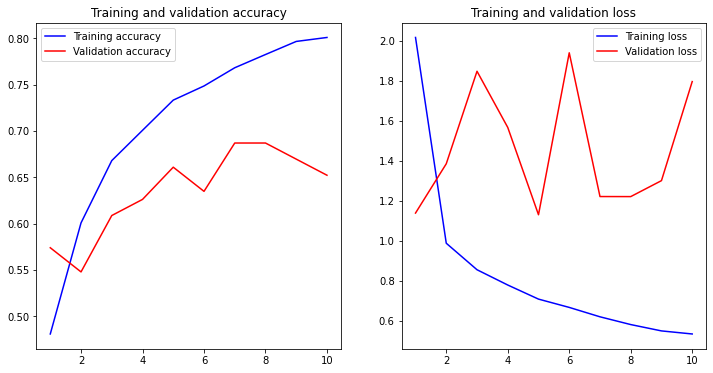

1.JPG: art_and_culture
10.JPG: art_and_culture
2.JPG: art_and_culture
3.JPG: art_and_culture
4.JPG: art_and_culture
5.JPG: travel_and_adventure
6.JPG: travel_and_adventure
7.JPG: travel_and_adventure
8.JPG: art_and_culture
9.JPG: art_and_culture


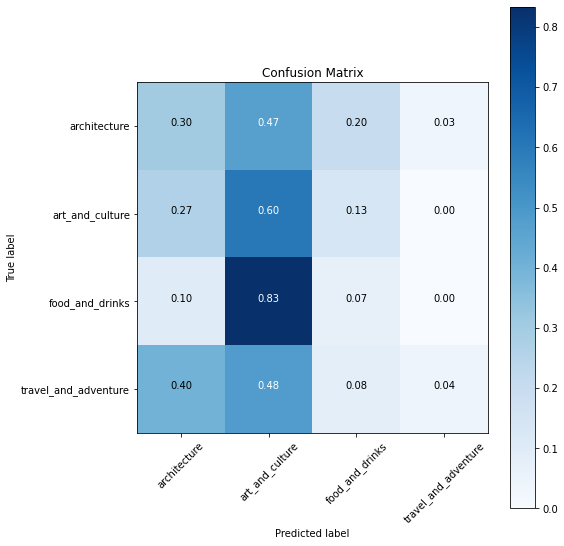

In [20]:

# Plot loss hsitory
plot_history(history)

# Predict the test dataset
predict_images(train_generator, model, TEST_DATA_DIR, img_width=IMG_WIDTH, img_height=IMG_HEIGHT, preprocess_input=None)

# Get confusion matrix
get_cm(model, validation_generator)


In [ ]:
model.save('mobilenet_image_classification.h5')

C:\Users\mahen\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


## GridSearch for hyperparameter tuning (optional)

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'optimizer': ['adam', 'rmsprop'],
    'learning_rate': [0.001, 0.0001],
    'batch_size': [32, 64],
    'epochs': [10, 20],
    'rotation_range': [20, 30],
    'width_shift_range': [0.2, 0.3],
    'height_shift_range': [0.2, 0.3],
    'shear_range': [0.2, 0.3],
    'zoom_range': [0.2, 0.3],
    'horizontal_flip': [True, False]
}

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

# Train the model using GridSearchCV
grid.fit(train_generator, validation_data=validation_generator)

# Print the best parameters and the corresponding mean cross-validated score
print("Best parameters: ", grid.best_params_)
print("Best score: ", grid.best_score_)